In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import warnings 
warnings.filterwarnings("ignore") 
%matplotlib inline 
card_df = pd.read_csv('./creditcard.csv' ) 
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [3]:
from sklearn.model_selection import train_test_split 

def get_preprocessed_df(df=None):
    df_copy=df.copy()
    df_copy.drop('Time',axis=1,inplace=True)
    return df_copy

In [5]:
def get_train_test_dataset(df=None):
    df_copy=get_preprocessed_df(df)
    
    X_features=df_copy.iloc[:,:-1]
    y_target=df_copy.iloc[:,-1]
    
    X_train,X_test,y_train,y_test=train_test_split(X_features,y_target,test_size=0.3,random_state=0,stratify=y_target)
    
    return X_train,X_test,y_train,y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df) 


In [6]:
print('학습데이터 레이블값 비율')
print(y_train.value_counts()/y_train.shape[0]*100)

print('테스트데이터 레이블값 비율')
print(y_test.value_counts()/y_test.shape[0]*100)

학습데이터 레이블값 비율
0    99.827451
1     0.172549
Name: Class, dtype: float64
테스트데이터 레이블값 비율
0    99.826785
1     0.173215
Name: Class, dtype: float64


In [12]:
from evalfuncs import get_clf_eval

로지스틱회귀 모델

In [13]:
from sklearn .linear_model import LogisticRegression 

In [14]:
lr_clf=LogisticRegression(max_iter=100)
lr_clf.fit(X_train,y_train)
lr_pred=lr_clf.predict(X_test)
lr_pred_proba=lr_clf.predict_proba(X_test)[:,1]

get_clf_eval(y_test,lr_pred,lr_pred_proba)

오차행렬
[[85283    12]
 [   57    91]]
정확도: 0.9992, 정밀도: 0.8835, 재현율: 0.6149, F1: 0.7251, AUC: 0.9608


LightGBM 기반 모델

In [21]:
def get_model_train_eval(model,ftr_train=None,ftr_test=None,tgt_train=None,tgt_test=None):
    model.fit(ftr_train,tgt_train)
    pred=model.predict(ftr_test)
    pred_proba=model.predict_proba(ftr_test)[:,1]
    get_clf_eval(tgt_test,pred,pred_proba)

In [16]:
from lightgbm import LGBMClassifier

lgbm_clf=LGBMClassifier(n_estimators=1000,num_leaves=64,n_jobs=-1,boost_from_average=False)
get_model_train_eval(lgbm_clf,ftr_train=X_train,ftr_test=X_test,tgt_train=y_train,tgt_test=y_test)

[LightGBM] [Info] Number of positive: 344, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047038 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199364, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

데이터 분포도 변환 후 모델 학습/예측/평가
* 왜곡된 분포도 가지는 데이터 재가공 후 모델을 다시 데스트

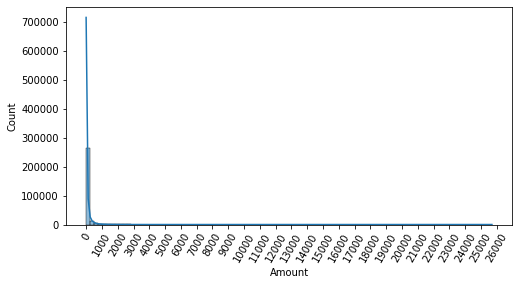

In [17]:
import seaborn as sns

plt.figure(figsize=(8,4))
plt.xticks(range(0,30000,1000), rotation=60)
sns.histplot(card_df['Amount'],bins=100,kde=True)
plt.show()

In [18]:
from sklearn.preprocessing import StandardScaler 

def get_preprocessed_df(df=None):
    df_copy=df.copy()
    scaler=StandardScaler()
    amount_n=scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1))
    df_copy.insert(0,'Amount_Scaled',amount_n)
    df_copy.drop(['Time','Amount'],axis=1,inplace=True)
    return df_copy

In [23]:
X_train , X_test , y_train , y_test = get_train_test_dataset(card_df)

print( '###로지스틱 회귀 예측 성능 ###') 
lr_clf = LogisticRegression(max_iter=1000) 
get_model_train_eval(lr_clf, ftr_train=X_train,ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print( "### LightGBM 예측 성능 ###") 
lgbm_clf = LGBMClassifier(n_estimators=1000 , num_leaves=64, n_jobs=-1 , boost_from_average=False) 
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train,tgt_test=y_test)

###로지스틱 회귀 예측 성능 ###
오차행렬
[[85281    14]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081, F1: 0.7143, AUC: 0.9702
### LightGBM 예측 성능 ###
[LightGBM] [Info] Number of positive: 344, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199364, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

<Axes: >

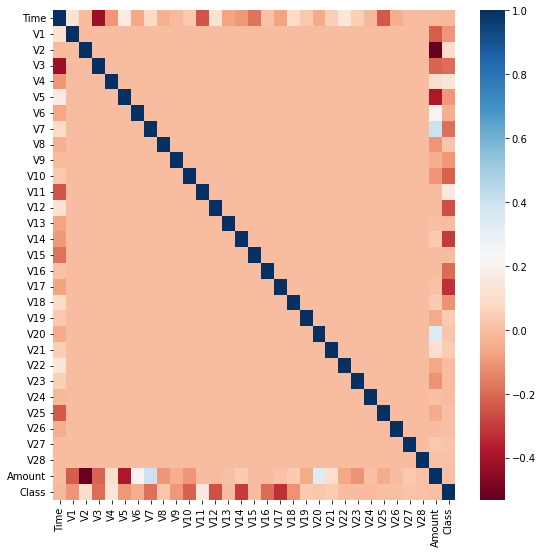

In [25]:
plt.figure(figsize=(9,9))
corr=card_df.corr()
sns.heatmap(corr,cmap='RdBu')

In [29]:
def get_outlier(df=None,column=None,weight=1.5):
    fraud=df[df['Class']==1][column]
    quantile_25=np.percentile(fraud.values,25)
    quantile_75=np.percentile(fraud.values,75)
    iqr=quantile_75-quantile_25
    iqr_weight=iqr*weight
    lowest_val=quantile_25-iqr_weight
    highest_val=quantile_75-iqr_weight
    outlier_index=fraud[(fraud<lowest_val)|(fraud>highest_val)].index
    return outlier_index

In [30]:
outlier_index=get_outlier(df=card_df,column='V14',weight=1.5)
print('이상치 데이터 인덱스: ', outlier_index)

이상치 데이터 인덱스:  Int64Index([   541,    623,   4920,   6108,   6329,   6331,   6334,   6336,
              6338,   6427,
            ...
            274382, 274475, 275992, 276071, 276864, 279863, 280143, 280149,
            281144, 281674],
           dtype='int64', length=433)


In [34]:
#get_processed_df를 로그변환+v14 이상치데이터 삭제로 변경

def get_preprocessed_df(df=None):
    df_copy = df.copy() 
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled' , amount_n) 
    df_copy.drop(['Time','Amount'], axis=1 , inplace=True )
    
    outlier_index=get_outlier(df=df_copy,column='V14',weight=1.5)
    df_copy.drop(outlier_index,axis=0,inplace=True)
    return df_copy

In [35]:
X_train,X_test,y_train,y_test=get_train_test_dataset(card_df)
print("### 로지스틱 회귀 예측 성능 ###")
get_model_train_eval(lr_clf,ftr_train=X_train,ftr_test=X_test,tgt_train=y_train,tgt_test=y_test)

print( '### LightGBM ###' ) 
get_model_train_eval(lgbm_clf,ftr_train=X_train,ftr_test=X_test,tgt_train=y_train,tgt_test=y_test)


### 로지스틱 회귀 예측 성능 ###
오차행렬
[[85293     2]
 [    1    17]]
정확도: 1.0000, 정밀도: 0.8947, 재현율: 0.9444, F1: 0.9189, AUC: 1.0000
### LightGBM ###
[LightGBM] [Info] Number of positive: 41, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199061, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가

In [40]:
!pip install imblearn

   ---------------------------------------- 258.0/258.0 kB 4.0 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [43]:
from imblearn.over_sampling import SMOTE

smote=SMOTE(random_state=0)
X_train_over,y_train_over=smote.fit_resample(X_train,y_train)
print("SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ",X_train.shape,y_train.shape)
print("SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ",X_train_over.shape,y_train_over.shape)
print("SMOTE 적용 후 레이블 값 분포: \n", pd.Series(y_train_over).value_counts())


SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (199061, 29) (199061,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포: 
 0    199020
1    199020
Name: Class, dtype: int64


In [44]:
lr_clf=LogisticRegression(max_iter=1000)
get_model_train_eval(lr_clf,ftr_train=X_train_over,ftr_test=X_test,tgt_train=y_train_over,tgt_test=y_test)

오차행렬
[[85292     3]
 [    1    17]]
정확도: 1.0000, 정밀도: 0.8500, 재현율: 0.9444, F1: 0.8947, AUC: 1.0000


In [46]:
from evalfuncs import precision_recall_curve_plot

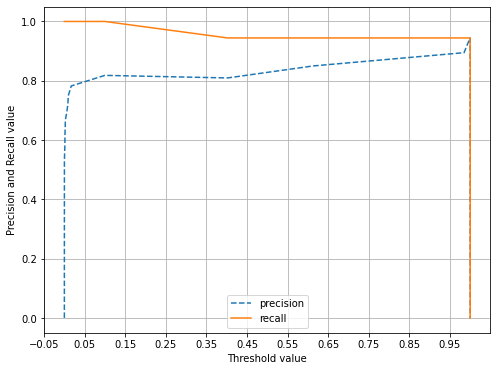

In [48]:
precision_recall_curve_plot(y_test,lr_clf.predict_proba(X_test)[:,1])

In [49]:
lgbm_clf=LGBMClassifier(n_estimators=1000,num_leaves=64,n_jobs=-1,boost_from_average=False)
get_model_train_eval(lgbm_clf,ftr_train=X_train_over,ftr_test=X_test,tgt_train=y_train_over,tgt_test=y_test)

[LightGBM] [Info] Number of positive: 199020, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.099963 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 398040, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split